# **Setup**

In [1]:
# !tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
import torch
print(torch.cuda.is_available())
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
!nvcc -V

True
Found GPU at: /device:GPU:0
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
import numpy as np
import glob
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import collections
from PIL import Image

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import pandas as pd


# **Load data**

In [3]:
# The given emotions dictionary represents numbers corresponding to each emotion label.
emotions = {
    '0': 'angry',     # 0 represents the 'angry' emotion.
    '1': 'fear',      # 1 represents the 'fear' emotion.
    '2': 'happy',     # 2 represents the 'happy' emotion.
    '3': 'neutral',   # 3 represents the 'neutral' emotion.
    '4': 'sad'        # 4 represents the 'sad' emotion.
}

# Creating a new dictionary emo by reversing the keys and values of the emotions dictionary.
emo = {
    value: key        # Using emotion labels as keys and their corresponding numbers as values.
    for key, value in emotions.items()  # Iterating over each item in the emotions dictionary.
}

# Printing the generated emo dictionary.
print(emo)

# The variable num_classes stores the number of emotion classes, which is the number of items in the emotions dictionary.
num_classes = len(emotions)


{'angry': '0', 'fear': '1', 'happy': '2', 'neutral': '3', 'sad': '4'}


In [4]:
def load_data(data_file):
    """
    Loads data from a given data file containing image paths and labels.

    Args:
        data_file (pandas.DataFrame): A DataFrame containing columns 'path' for image paths and 'label' for emotion labels.

    Returns:
        numpy.ndarray, numpy.ndarray: Arrays of images (x_data) and corresponding emotion labels (y_data).
    """
    print('Loading data ...')
    x_data = []  # List to store image arrays.
    y_data = []  # List to store emotion labels.
    
    for i in range(len(data_file)):
        try:
            img = Image.open(data_file.iloc[i]['path'])  # Open the image using PIL.
            label = emo[data_file.iloc[i]['label']]  # Get emotion label using the emo dictionary.
            img_array = np.array(img)  # Convert the image to a numpy array.
            x_data.append(img_array)  # Append image array to x_data.
            y_data.append(label)  # Append emotion label to y_data.
        except FileNotFoundError:
            print(f"{img} doesn't exist")
    
    x_data = np.array(x_data)  # Convert the list of image arrays to a numpy array.
    y_data = np.array(y_data)  # Convert the list of emotion labels to a numpy array.
    print('Data loaded.')
    return x_data, y_data

def exist_check(dataset):
    """
    Checks the existence of images in the given dataset and creates a new dataset CSV file.

    Args:
        dataset (pandas.DataFrame): A DataFrame containing columns 'path' for image paths and 'label' for emotion labels.
    """
    print('Loading data ...')
    db = []  # List to store image path-label pairs.
    
    for i in range(len(dataset)):
        try:
            path = dataset.iloc[i]['path']  # Get the image path.
            label = dataset.iloc[i]['label']  # Get the emotion label.
            img = Image.open(path)  # Open the image using PIL.
            db.append({'path': path, 'label': label})  # Append the path-label pair to the list.
        except FileNotFoundError:
            print(f"{path} doesn't exist.")
    
    pd.DataFrame(db).to_csv("dataset2.csv", index=False)  # Create a new CSV dataset file.

In [5]:
data_file = pd.read_csv('./dataset.csv')  # Load the dataset CSV file into a pandas DataFrame.
exist_check(data_file)  # Call the exist_check function to check image existence and create a new dataset CSV file.

Loading data ...
./dataset/angry_unilacaqbxbtjbypudkqufegboxtnd.jpg don't exist.
./dataset/angry_wnpdejtkwseeapcxiatqelbdedralb.jpg don't exist.
./dataset/angry_rcxvnxkvhlelqiexjabjvqxxmaiiyb.jpg don't exist.
./dataset/angry_ujhwtylniafvdxdksmtpkmloofsaxt.jpg don't exist.
./dataset/angry_ftqrtohfnudlinmffcauvecoejniod.jpg don't exist.
./dataset/angry_vytonotgrewhwbanbvstqlkaacpjre.jpg don't exist.
./dataset/angry_mbmnmnablyvxldyrdpwdcwtcqlhxxw.jpg don't exist.
./dataset/angry_agbygqiixxmscfeikbeikkxowonlcm.jpg don't exist.
./dataset/angry_vfmfftafauudgymirxamjtjjdxwmld.jpg don't exist.
./dataset/angry_cckgjewiypimdibtauvkvyrdshhrqs.jpg don't exist.
./dataset/angry_bqkejekelugkvxlmvijytbmrbyyjnq.jpg don't exist.
./dataset/angry_aqmtmmegcemjjirrxiuoqdjwiggdht.jpg don't exist.
./dataset/angry_ghlilrmslytcumxrdcreuqqmjfgjeu.jpg don't exist.
./dataset/angry_txaibflcfywwpcauanwtlifqcehvwv.jpg don't exist.
./dataset/angry_yvrtutoocikcuyxrkonagreioagvwi.jpg don't exist.
./dataset/angry_topcemf

In [6]:
data_file = pd.read_csv('./dataset.csv')  # Load the dataset CSV file into a pandas DataFrame.

# Load images and labels using the load_data function.
images, labels = load_data(data_file)

# Get the number of samples in the dataset.
n_samples = labels.shape[0]

# Print the total number of samples, shape of images array, and shape of labels array.
print('Total samples:', n_samples)       # Display the total number of samples.
print('images shape:', images.shape)     # Display the shape of the images array (number of samples, height, width, channels).
print('labels shape:', labels.shape)     # Display the shape of the labels array (number of samples).


Loading data ...
Data loaded.
Total samples: 351850
images shape: (351850, 48, 48)
labels shape: (351850,)


In [7]:
# Print the unique labels and their corresponding counts.
print(np.unique(labels, return_counts=True))

(array(['0', '1', '2', '3', '4'], dtype='<U1'), array([ 48156, 104437,  49060,  47734, 102463]))


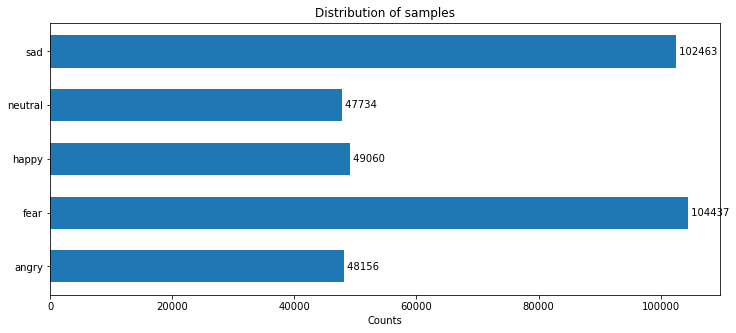

In [8]:
def plot_sample_distribution(labels):
    """
    Plots the distribution of samples for each emotion class.

    Args:
        labels (numpy.ndarray): An array containing emotion labels for each sample.

    Returns:
        None
    """
    classes, cnts = np.unique(labels, return_counts=True)  # Calculate unique labels and their counts.
    plt.figure(figsize=(12, 5))  # Create a new figure with a specific size.
    plt.barh(list(emotions.values()), cnts, height=0.6)  # Create a horizontal bar plot.
    for i, v in enumerate(cnts):
        plt.text(v, i, ' ' + str(v), va='center')  # Display the count value on each bar.
    plt.xlabel('Counts')  # Set the label for the x-axis.
    plt.title("Distribution of samples")  # Set the title of the plot.

# Call the function to plot the sample distribution based on the 'labels' array.
plot_sample_distribution(labels)

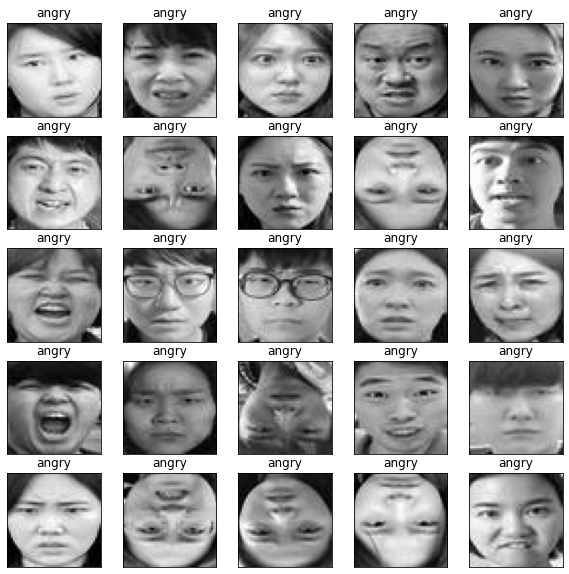

In [9]:
def show_images(images, labels, col=5):
    """
    Displays a grid of images along with their corresponding emotion labels.

    Args:
        images (numpy.ndarray): An array containing image data.
        labels (numpy.ndarray): An array containing emotion labels for each image.
        col (int, optional): Number of columns in the grid. Defaults to 5.

    Returns:
        None
    """
    n = images.shape[0]  # Get the total number of images.
    row = int(np.ceil(n / col))  # Calculate the number of rows based on the given number of columns.
    fig = plt.figure(figsize=(2 * col, 2 * row))  # Create a figure for displaying the grid.

    for i in range(n):
        fig.add_subplot(row, col, i + 1)  # Add a subplot for each image.
        plt.imshow(images[i], cmap='gray')  # Display the image using a grayscale colormap.
        plt.title(emotions[labels[i]])  # Set the title of the subplot as the corresponding emotion label.
        plt.xticks([]), plt.yticks([])  # Remove x and y axis ticks.

    plt.show()  # Display the grid of images.

# Call the function to display the first 25 images along with their labels.
show_images(images[:25], labels[:25])


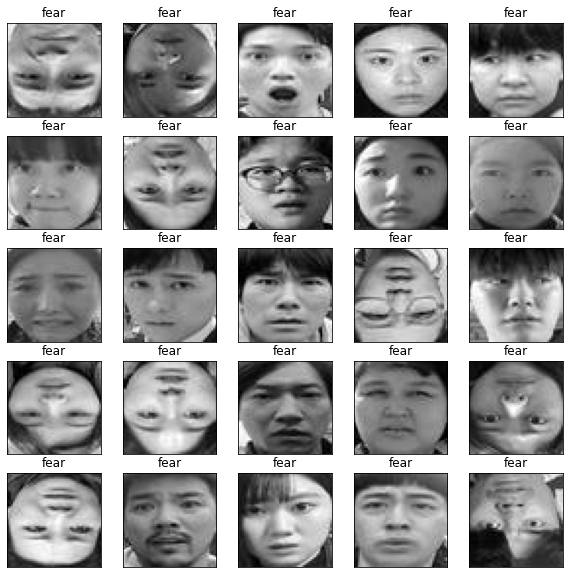

In [10]:
def show_one_emotion(images, labels, id, start=0, num=25):
    """
    Displays a grid of images belonging to a specific emotion label.

    Args:
        images (numpy.ndarray): An array containing image data.
        labels (numpy.ndarray): An array containing emotion labels for each image.
        id (str or int): The emotion label to display images for.
        start (int, optional): Index to start selecting images from. Defaults to 0.
        num (int, optional): Number of images to display. Defaults to 25.

    Returns:
        None
    """
    image_x = images[labels == id]  # Filter images based on the given emotion label.
    label_x = labels[labels == id]  # Filter labels based on the given emotion label.
    
    # Call the show_images function to display the selected images with the filtered labels.
    show_images(image_x[start:start + num], label_x[start:start + num])

# Call the function to display images for a specific emotion label.
show_one_emotion(images, labels, id='1')


# **Split dataset**

In [11]:
# Split the dataset into training, validation, and test sets.
# Training set: 64%, Validation set: 16%, Test set: 20%
image_train, image_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
image_train, image_val, label_train, label_val = train_test_split(image_train, label_train, test_size=0.2, random_state=42)

# Print the number of samples in each dataset split.
print('Training samples:', label_train.shape[0])  # Display the number of samples in the training set.
print('Validation samples:', label_val.shape[0])  # Display the number of samples in the validation set.
print('Test samples:', label_test.shape[0])  # Display the number of samples in the test set.

Training samples: 225184
Validation samples: 56296
Test samples: 70370


# **Upsamling training data**

In [12]:
def upsampling(x, y, strategy):
    """
    Performs upsampling using the SMOTE technique to balance class distribution.

    Args:
        x (numpy.ndarray): An array containing image data.
        y (numpy.ndarray): An array containing target labels.
        strategy (float, str, dict or callable): Strategy to use for resampling.

    Returns:
        numpy.ndarray, numpy.ndarray: Upsampled image data and corresponding labels.
    """
    (n, w, h) = x.shape  # Get the dimensions of the input image data.
    sm = SMOTE(sampling_strategy=strategy, random_state=42)  # Create a SMOTE object with the given strategy.
    x_flat = x.reshape((n, -1))  # Reshape the input image data to a 2D array.
    x_up, y_up = sm.fit_resample(x_flat, y)  # Perform resampling using SMOTE.
    n_up = x_up.shape[0]  # Get the number of samples in the upsampled data.
    x_up = x_up.reshape((n_up, w, h))  # Reshape the upsampled data to its original shape.

    return x_up, y_up  # Return the upsampled image data and corresponding labels.

In [13]:
# Count the occurrences of each label in the 'label_train' array using the Counter class from the collections module.
collections.Counter(label_train)

Counter({'4': 65334, '1': 66968, '3': 30554, '2': 31493, '0': 30835})

In [14]:
# Perform upsampling on the training data using the upsampling function.
# The 'auto' strategy is used to determine the sampling ratio automatically.
image_train_up, label_train_up = upsampling(image_train, label_train, 'auto')

In [15]:
# Count the occurrences of each label in the 'label_train_up' array after performing upsampling.
collections.Counter(label_train_up)

Counter({'4': 66968, '1': 66968, '3': 66968, '2': 66968, '0': 66968})

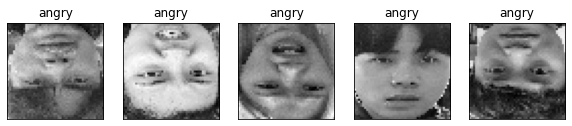

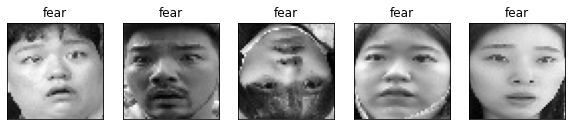

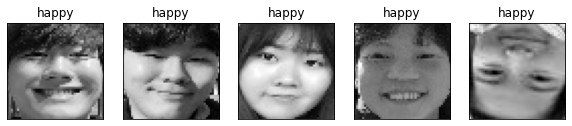

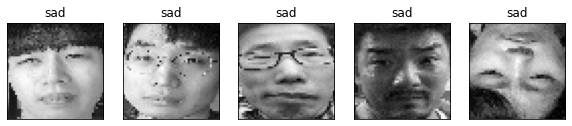

In [16]:
# Iterate through each emotion class except class 3.
for i in range(num_classes):
    if i == 3:  # Skip class 3 (neutral) using the 'continue' statement.
        continue
    # Display a grid of upsampled images belonging to the current emotion class.
    show_one_emotion(image_train_up, label_train_up, id=f'{i}', start=4000, num=5)

# **Utils**

In [17]:
def one_hot_encoding(labels, num_classes):
    """
    Performs one-hot encoding on the given labels.

    Args:
        labels (numpy.ndarray): An array containing integer labels.
        num_classes (int): The total number of classes.

    Returns:
        numpy.ndarray: An array of one-hot encoded labels.
    """
    return tf.keras.utils.to_categorical(labels, num_classes)


In [18]:
def reshape_images(images, channel=1, resize=None):
    """
    Reshapes and preprocesses a batch of images.

    Args:
        images (numpy.ndarray): An array containing image data.
        channel (int, optional): Number of channels for the images. Defaults to 1.
        resize (tuple, optional): Desired image dimensions after resizing. Defaults to None.

    Returns:
        tensorflow.Tensor: A tensor of preprocessed images.
    """
    # Convert the input image data to a tensor and add an additional channel dimension.
    x = tf.expand_dims(tf.convert_to_tensor(images), axis=3)
    
    if channel > 1:
        x = tf.repeat(x, channel, axis=3)  # Repeat the channel to match the desired number of channels.

    if resize is not None:
        x = tf.image.resize(x, resize)  # Resize the images to the desired dimensions.

    return x  # Return the preprocessed image tensor.

In [19]:
def pre_processing(images, labels, num_classes, channel=1, resize=None, one_hot=True):
    """
    Pre-processing function: Accepts images and labels for processing.

    Args:
        images (list or numpy.ndarray): List of image data or NumPy array.
        labels (list or numpy.ndarray): List of label data or NumPy array.
        num_classes (int): Total number of classes.
        channel (int, optional): Number of channels in the images. Default is 1.
        resize (tuple, optional): Target size for image resizing (height, width). Default is None.
        one_hot (bool, optional): Apply one-hot encoding if True. Default is True.

    Returns:
        tuple: A tuple containing pre-processed image data and label data (x, y).

    """
    x = reshape_images(images, channel, resize)
    y = one_hot_encoding(labels, num_classes)
    return x, y


In [20]:
def plot_metrics(history):
    """
    Plot training metrics over epochs.

    This function generates a side-by-side plot of training and validation metrics
    (e.g., loss and accuracy) over the course of training epochs.

    Args:
        history (keras.callbacks.History): The object returned by the `fit` method of a Keras model.

    Returns:
        None

    """
    metrics = ['loss', 'accuracy']
    plt.figure(figsize=(15, 6))
    plt.rc('font', size=12)
    
    for n, metric in enumerate(metrics):
        name = metric.capitalize()
        plt.subplot(1, 2, n+1)
        plt.plot(history.epoch, history.history[metric], label='Training', lw=3, color='navy')
        plt.plot(history.epoch, history.history['val_'+metric], lw=3, label='Validation', color='deeppink')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.title('Model ' + name)
        plt.legend()

    plt.show()

In [21]:
def evaluate_class(model, x_test, y_test):
    """
    Evaluate the model's performance on different classes and overall accuracy.

    This function evaluates a given model's performance on individual classes as well as
    the overall accuracy on the provided test data.

    Args:
        model (keras.models.Model): A trained Keras model.
        x_test (numpy.ndarray): Test input data.
        y_test (numpy.ndarray): True labels for the test data.

    Returns:
        None

    """
    labels = np.argmax(y_test, axis=1)
    print('{:<15}Accuracy'.format('Emotion'))
    print('-'*23)
    
    for i in range(num_classes):
        x = x_test[labels == i]
        y = y_test[labels == i]
        loss, acc = model.evaluate(x, y, verbose=0)
        print('{:<15}{:.1%}'.format(emotions[f'{i}'], acc))
    
    print('-'*23)
    loss, acc = model.evaluate(x_test, y_test, verbose=0)
    print('{:<15}{:.1%}'.format('Overall', acc))


# **Model**

In [22]:

def model_checkpoint_cb(file_path):
    """
    Create a ModelCheckpoint callback for saving the best model during training.

    This function creates a Keras ModelCheckpoint callback that monitors the validation accuracy
    and saves the model's weights when the validation accuracy improves.

    Args:
        file_path (str): Path to save the model file, including the filename.

    Returns:
        keras.callbacks.ModelCheckpoint: A ModelCheckpoint callback instance.

    """
    return ModelCheckpoint(
        file_path, monitor='val_accuracy', mode='max',
        save_best_only=True, save_weights_only=False, verbose=1)

In [24]:
# Data Preprocessing
x_train, y_train = pre_processing(image_train_up, label_train_up, num_classes)
x_val, y_val = pre_processing(image_val, label_val, num_classes)
x_test, y_test = pre_processing(image_test, label_test, num_classes)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen = ImageDataGenerator()

# Batch Size
batch_size = 128

# Creating Data Generators
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(x_val, y_val)

# Setting Training Parameters
steps_per_epoch = train_generator.n // train_generator.batch_size
input_shape = x_train[0].shape


In [25]:
# one_batch = train_generator.next()
# one_batch_images = one_batch[0].reshape((128,48,48))
# one_batch_labels = np.argmax(one_batch[1], axis=1)
# show_images(one_batch_images[:25], one_batch_labels[:25])

In [27]:
class VGGNet(Sequential):
    def __init__(self, input_shape, num_classes, checkpoint_path, lr=1e-3):
        """
        VGG-like Convolutional Neural Network model.

        This class defines a VGG-like Convolutional Neural Network model using the Keras Sequential API.

        Args:
            input_shape (tuple): Shape of input images (height, width, channels).
            num_classes (int): Number of classes for classification.
            checkpoint_path (str): Path to save checkpoints during training.
            lr (float, optional): Learning rate for the optimizer. Default is 1e-3.

        Returns:
            None

        """
        super().__init__()

        self.add(Rescaling(1./255, input_shape=input_shape))
        
        # Convolutional Blocks
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal'))
        self.add(BatchNormalization())
        self.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))

        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.5))

        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same'))
        self.add(BatchNormalization())
        self.add(MaxPool2D())
        self.add(Dropout(0.4))
        
        # Fully Connected Layers
        self.add(Flatten())
        self.add(Dense(1024, activation='relu'))
        self.add(Dropout(0.5))
        self.add(Dense(256, activation='relu'))

        # Output Layer
        self.add(Dense(num_classes, activation='softmax'))

        # Compile the Model
        self.compile(optimizer=Adam(learning_rate=lr),
                     loss=categorical_crossentropy,
                     metrics=['accuracy'])

        # Save Checkpoint Path
        self.checkpoint_path = checkpoint_path


In [29]:
# Create a VGGNet model instance
model = VGGNet(input_shape, num_classes, './vggnet_up.h5')

# Display model summary
model.summary()

Model: "vgg_net_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 23, 23, 64)        0 

In [30]:

import telegram
import asyncio
import nest_asyncio

In [31]:
# Set the number of training epochs
epochs = 1000

# Define callbacks for model training
cp = model_checkpoint_cb(model.checkpoint_path)  # Create ModelCheckpoint callback
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, min_lr=1e-10)  # Create LearningRateScheduler callback
es = EarlyStopping(monitor='val_loss', verbose=1, patience=70)  # Create EarlyStopping callback

try:
    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[lr, es, cp])  # Apply defined callbacks during training
except Exception as e:
    nest_asyncio.apply()  # Handle nested asyncio event loops
    bot = telegram.Bot(token="6441009419:AAGeU_ZUW6pxvqAOwIcIA8-PH8RLRPgb9rQ")  # Initialize a Telegram bot instance
    chat_id = "5862996909"
    asyncio.run(bot.send_message(chat_id=chat_id, text="An error occurred in Jupyter Notebook"))  # Send an error message
    raise KeyboardInterrupt  # Raise KeyboardInterrupt to stop execution

Epoch 1/1000
2615/2615 [==============================] - 125s 45ms/step - loss: 1.5201 - accuracy: 0.3210 - val_loss: 0.9930 - val_accuracy: 0.5960

Epoch 00001: val_accuracy improved from -inf to 0.59597, saving model to ./vggnet_up.h5
Epoch 2/1000
2615/2615 [==============================] - 117s 45ms/step - loss: 0.9683 - accuracy: 0.6079 - val_loss: 0.9399 - val_accuracy: 0.6368

Epoch 00002: val_accuracy improved from 0.59597 to 0.63676, saving model to ./vggnet_up.h5
Epoch 3/1000
2615/2615 [==============================] - 118s 45ms/step - loss: 0.8147 - accuracy: 0.6803 - val_loss: 0.7432 - val_accuracy: 0.7120

Epoch 00003: val_accuracy improved from 0.63676 to 0.71197, saving model to ./vggnet_up.h5
Epoch 4/1000
2615/2615 [==============================] - 118s 45ms/step - loss: 0.7624 - accuracy: 0.7049 - val_loss: 0.7822 - val_accuracy: 0.6953

Epoch 00004: val_accuracy did not improve from 0.71197
Epoch 5/1000
2615/2615 [==============================] - 118s 45ms/step - 

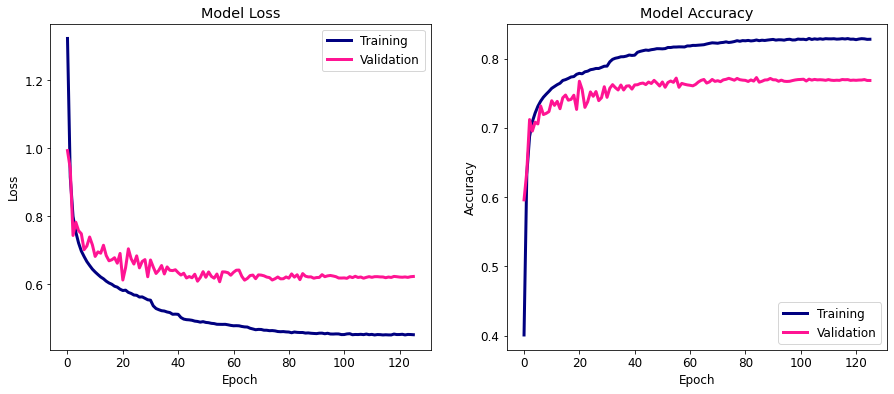

In [32]:
# Plot training metrics
plot_metrics(history)

In [33]:
# Load the best model weights from checkpoint
model.load_weights(model.checkpoint_path)

# Evaluate model on test data by class and overall accuracy
evaluate_class(model, x_test, y_test)

Emotion        Accuracy
-----------------------
angry          69.0%
fear           66.7%
happy          95.0%
neutral        82.3%
sad            80.3%
-----------------------
Overall        77.1%


In [34]:
# Save the trained model
model.save('./vggnet_trained.h5')

In [35]:
# Handle nested asyncio event loops
nest_asyncio.apply()

# Initialize a Telegram bot instance
bot = telegram.Bot(token="6441009419:AAGeU_ZUW6pxvqAOwIcIA8-PH8RLRPgb9rQ")
chat_id = "5862996909"

# Send a completion message to Telegram
asyncio.run(bot.send_message(chat_id=chat_id, text="주피터 완료"))

Message(channel_chat_created=False, chat=Chat(first_name='SungWook', id=5862996909, last_name='Jung', type=<ChatType.PRIVATE>), date=datetime.datetime(2023, 8, 20, 21, 45, 18, tzinfo=<UTC>), delete_chat_photo=False, from_user=User(first_name='jupyterbot', id=6441009419, is_bot=True, username='oceanstarbot'), group_chat_created=False, message_id=49, supergroup_chat_created=False, text='주피터 완료')